# Прогнозирование заказов такси

**Задача**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

**Описание данных**

* `datetime` - дата и время

* `num_orders` - количество заказов

In [1]:
!pip install prophet

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

C:\Users\gturk\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Изучение данных и подбор подготовка признаков

In [2]:
data = pd.read_csv('taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В наших данных отсутствуют пропуски. На всякий случай проверим наличие дубликатов

In [4]:
data.duplicated().sum()

0

Дубликатов тоже нет. Переведем колонку `'datetime'` в тип `datetime64` и выполним ресемплинг по одному часу

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data = data.resample('h').sum()
data = data.reset_index()

In [6]:
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43
5,2018-03-01 05:00:00,6
6,2018-03-01 06:00:00,12
7,2018-03-01 07:00:00,15
8,2018-03-01 08:00:00,34
9,2018-03-01 09:00:00,69


Теперь проведем анализ наших данных

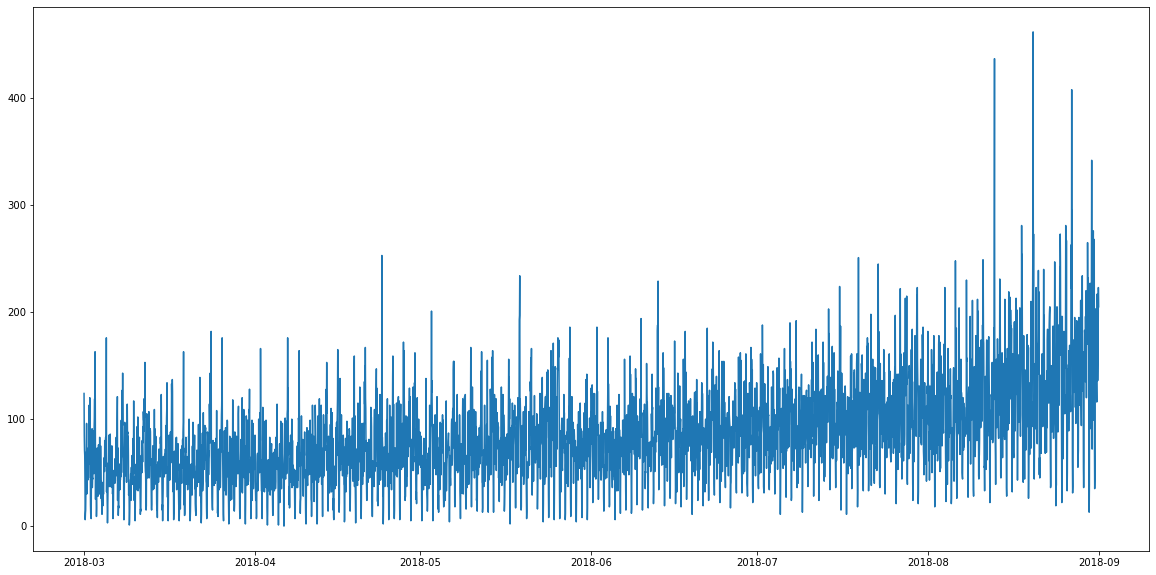

In [7]:
plt.figure(figsize=(20,10))
plt.plot(data['datetime'], data['num_orders'])
plt.show()

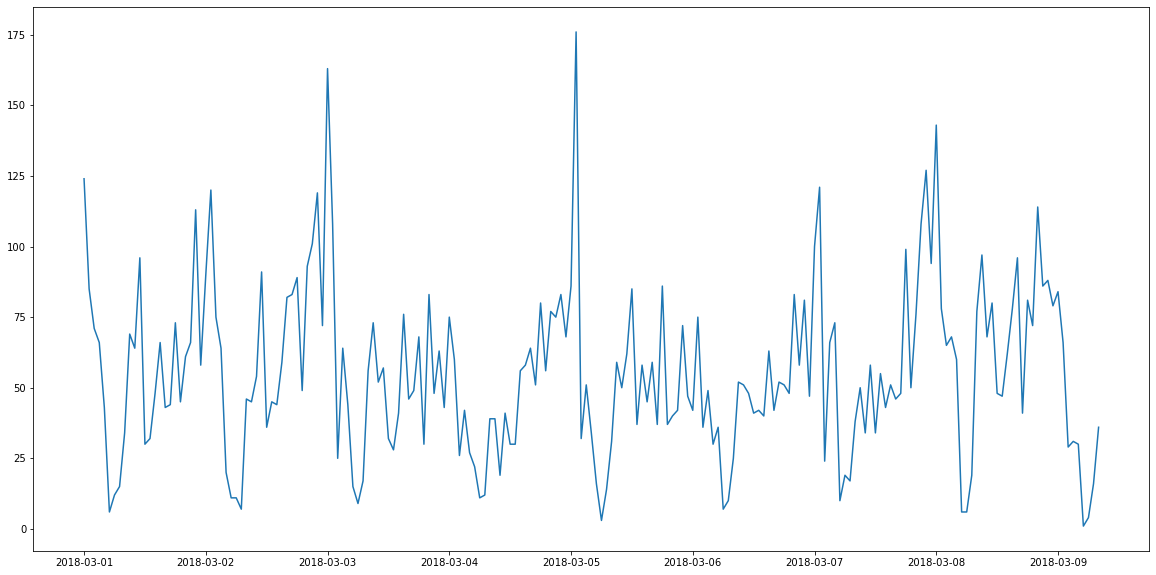

In [8]:
plt.figure(figsize=(20,10))
plt.plot(data.loc[:200, 'datetime'], data.loc[:200, 'num_orders'])
plt.show()

Уже визуальный анализ говорит о том, что в наших данных есть довольно четко выраженный тренд, а также некоторая сезонность. Для более тщательного анализа, а также генерации новых фичей, воспользуемся библиотекой Prophet. Но сначала разделим данные на тренировочную, валидационную и тестовую выборки

In [9]:
decomposed = seasonal_decompose(data.set_index('datetime'))

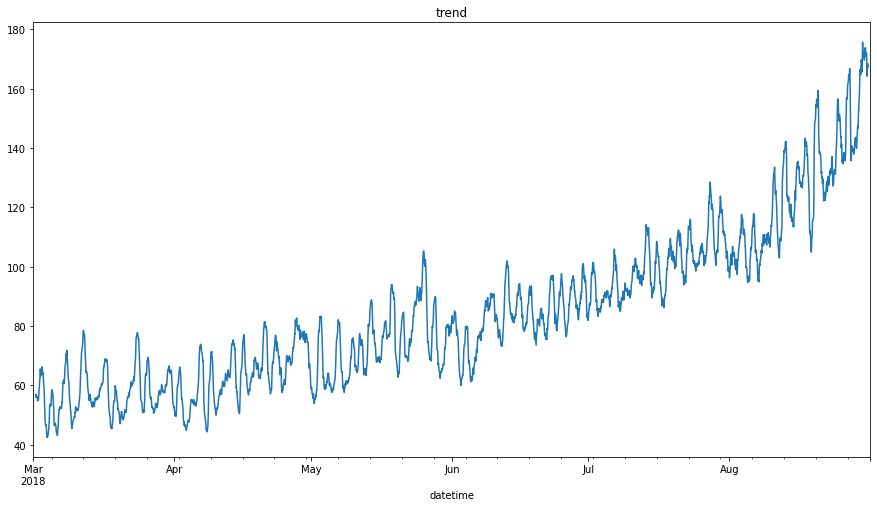

In [10]:
plt.figure(figsize=(15, 8))
decomposed.trend.plot(ax=plt.gca())
plt.title('trend');

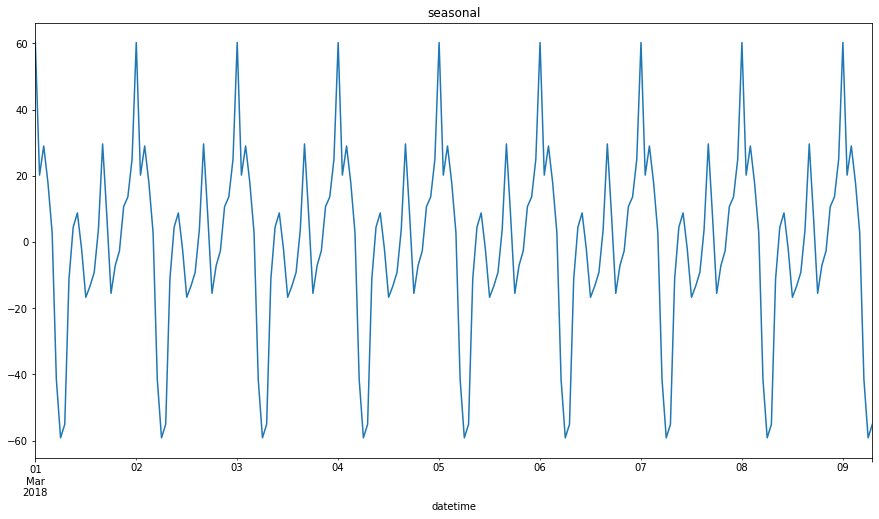

In [11]:
plt.figure(figsize=(15, 8))
decomposed.seasonal[:200].plot(ax=plt.gca())
plt.title('seasonal');

Видно, что в данных присутствует возрастающий тренд, а также четко выраженная дневная сезонность. Пик заказов приходится примерно на 23:00-01:00, потом идет резкий спад, подъем наблюдается только утром; далее в течение дня есть некоторые колебания, а к ночи снова пик

In [12]:
data = data.rename(columns={'datetime' : 'ds', 'num_orders' : 'y'})

In [13]:
train, valid = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)

In [14]:
train.head()

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


In [15]:
valid.head()

,ds,y
3532,2018-07-26 04:00:00,131
3533,2018-07-26 05:00:00,83
3534,2018-07-26 06:00:00,21
3535,2018-07-26 07:00:00,39
3536,2018-07-26 08:00:00,80


In [16]:
test.head()

,ds,y
3974,2018-08-13 14:00:00,102
3975,2018-08-13 15:00:00,175
3976,2018-08-13 16:00:00,144
3977,2018-08-13 17:00:00,152
3978,2018-08-13 18:00:00,104


Создадим модель, обучим ее и выполним предсказания

In [17]:
prophet_model = Prophet()
prophet_model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [18]:
future = pd.concat([train, valid]).drop('y', axis=1).reset_index(drop=True)
future

,ds
0,2018-03-01 00:00:00
1,2018-03-01 01:00:00
2,2018-03-01 02:00:00
3,2018-03-01 03:00:00
4,2018-03-01 04:00:00
...,...
3969,2018-08-13 09:00:00
3970,2018-08-13 10:00:00
3971,2018-08-13 11:00:00
3972,2018-08-13 12:00:00


In [19]:
forecast = prophet_model.predict(future)

Построим графики предсказаний и разложения временного ряда на компоненты: тренд и различные сезонности

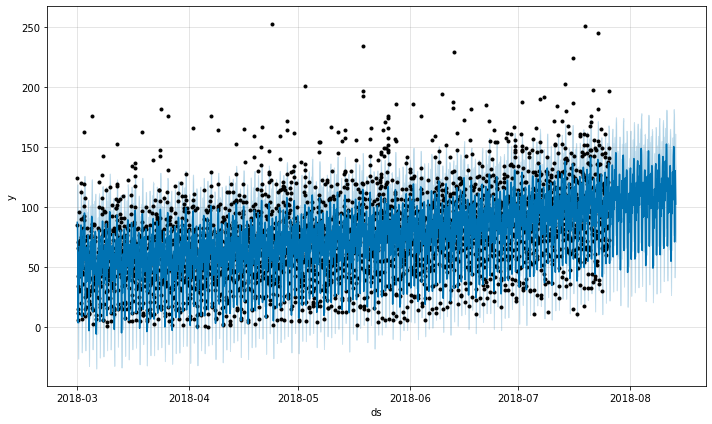

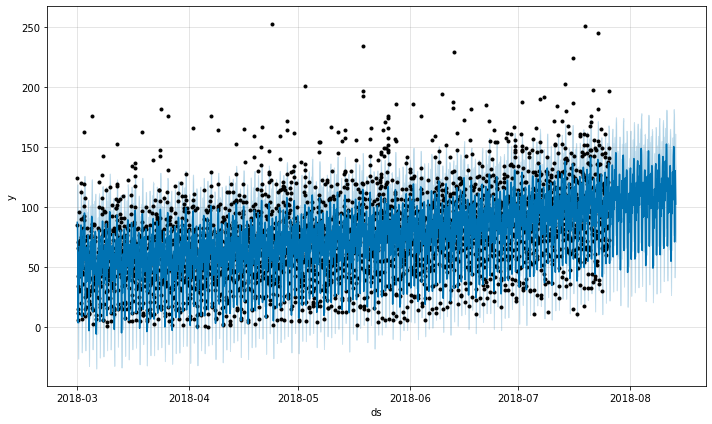

In [20]:
prophet_model.plot(forecast)

In [21]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-01 00:00:00,54.422282,54.569786,117.693689,54.422282,54.422282,32.986060,32.986060,32.986060,30.398582,30.398582,30.398582,2.587478,2.587478,2.587478,0.0,0.0,0.0,87.408342
1,2018-03-01 01:00:00,54.428467,58.933029,119.164480,54.428467,54.428467,32.169115,32.169115,32.169115,30.045631,30.045631,30.045631,2.123484,2.123484,2.123484,0.0,0.0,0.0,86.597582
2,2018-03-01 02:00:00,54.434652,52.976927,111.352961,54.434652,54.434652,27.640696,27.640696,27.640696,26.008029,26.008029,26.008029,1.632668,1.632668,1.632668,0.0,0.0,0.0,82.075348
3,2018-03-01 03:00:00,54.440836,37.376605,96.515892,54.440836,54.440836,13.647133,13.647133,13.647133,12.522876,12.522876,12.522876,1.124257,1.124257,1.124257,0.0,0.0,0.0,68.087970
4,2018-03-01 04:00:00,54.447021,14.555711,73.394706,54.447021,54.447021,-11.001912,-11.001912,-11.001912,-11.609605,-11.609605,-11.609605,0.607693,0.607693,0.607693,0.0,0.0,0.0,43.445110


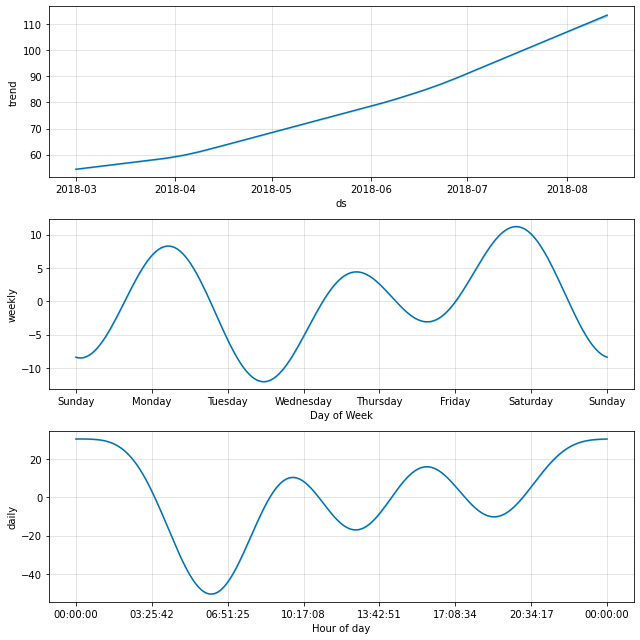

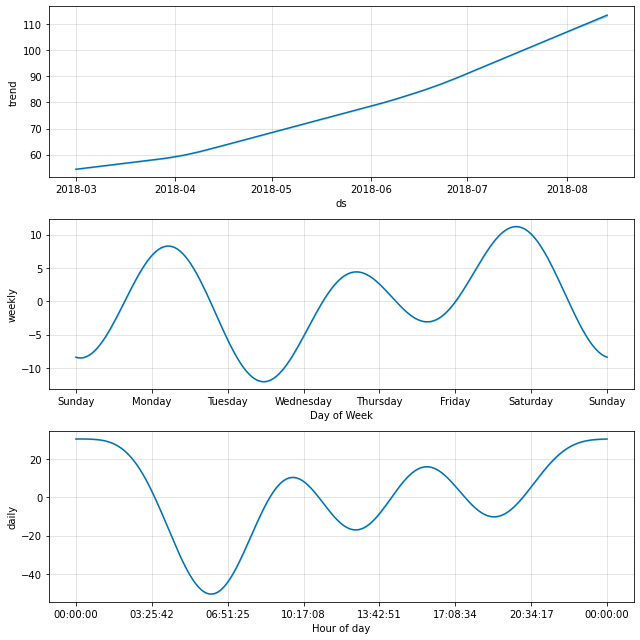

In [22]:
prophet_model.plot_components(forecast)

Теперь отчетливо видно, что в данных есть растущий тренд и четко выраженная сезонность, причем как недельная, так и дневная. В ночь с воскресенья на понедельник, вечером в среду, а также в ночь на субботу наблюдаются пики заказов. Во вторник и в четверг - провалы. Теперь про дневную зависимость. Больше всего вызовов такси в ночное время, это и логично, автобусы в это время не ходят. Ближе к семи утра видим резкий спад, потом подъем и колебания, после чего снова подъем количества вызовов в ночное время

Добавим предсказания (колонку `'yhat'`) в качестве фичи

In [23]:
train.shape, future.shape

((3532, 2), (3974, 1))

In [24]:
train['prophet_prediction'] = forecast['yhat'].iloc[:3532]
valid['prophet_prediction'] = forecast['yhat'].iloc[3532:]

Добавим новые фичи: календарные признаки, лаги и скользящее среднее. Так как у нас данные всего за полгода, то нет смысла добавлять фичи, связанные с годом и месяцем. Добавим дни недели и часы.

In [25]:
train['dayofweek'] = train['ds'].apply(lambda x: x.dayofweek)
valid['dayofweek'] = valid['ds'].apply(lambda x: x.dayofweek)
test['dayofweek'] = test['ds'].apply(lambda x: x.dayofweek)

In [26]:
train['hour'] = train['ds'].apply(lambda x: x.hour)
valid['hour'] = valid['ds'].apply(lambda x: x.hour)
test['hour'] = test['ds'].apply(lambda x: x.hour)

In [27]:
train.head()

,ds,y,prophet_prediction,dayofweek,hour
0,2018-03-01 00:00:00,124,87.408342,3,0
1,2018-03-01 01:00:00,85,86.597582,3,1
2,2018-03-01 02:00:00,71,82.075348,3,2
3,2018-03-01 03:00:00,66,68.087970,3,3
4,2018-03-01 04:00:00,43,43.445110,3,4


Добавим лаги

In [28]:
lags_count = 3
for i in range(1, lags_count + 1):
    train['lag_{}'.format(i)] = train['y'].shift(i)
train.head()

,ds,y,prophet_prediction,dayofweek,hour,lag_1,lag_2,lag_3
0,2018-03-01 00:00:00,124,87.408342,3,0,NaN,NaN,NaN
1,2018-03-01 01:00:00,85,86.597582,3,1,124.0,NaN,NaN
2,2018-03-01 02:00:00,71,82.075348,3,2,85.0,124.0,NaN
3,2018-03-01 03:00:00,66,68.087970,3,3,71.0,85.0,124.0
4,2018-03-01 04:00:00,43,43.445110,3,4,66.0,71.0,85.0


Добавим скользящее среднее с двумя окнами: 24 и 24*7, чтобы подчеркнуть дневную и недельную сезонности

In [29]:
daily_size = 24
weekly_size = 24 * 7
train['rolling_mean_daily'] = train['y'].rolling(daily_size, closed='left').mean()
train['rolling_mean_weekly'] = train['y'].rolling(weekly_size, closed='left').mean()

In [30]:
train.isna().sum()

ds                       0
y                        0
prophet_prediction       0
dayofweek                0
hour                     0
lag_1                    1
lag_2                    2
lag_3                    3
rolling_mean_daily      24
rolling_mean_weekly    168
dtype: int64

In [31]:
train.shape[0]

3532

В результате добаления фичей в данных вознили пропуски. Удалим строки с пропусками

In [32]:
train = train.iloc[168:]

## Работа с моделями

Итак, теперь у нас имеется некоторый набор фичей. Прежде чем начать работать с моделями, напишем функцию для выполнения предсказаний

In [33]:
def make_prediction(model, test_frame, train_frame):
    """
    Params:
    
    model - обученная модель
    test_frame - набор данных для предсказания; должен содержать все колонки, кроме лагов, скользящих средних и целевого признака
    train_frame - набор данных, на котором обучалась модель
    
    !!! В обоих наборах данных должна отсутствовать дата
    
    Returns:
    
    list of predictions, final test_frame
    """
    predictions = []
    
    # 168 = 24 * 7 - количество записей в неделю
    cur_frame = train_frame.iloc[-168:]
    
    for i in range(test_frame.shape[0]):
        cur_frame.loc[cur_frame.shape[0]] = test_frame.iloc[i]
        # Добавляем скользящее среднее
        cur_frame['rolling_mean_daily'].iloc[-1] = cur_frame['y'].iloc[-25 : -1].mean()
        cur_frame['rolling_mean_weekly'].iloc[-1] = cur_frame['y'].iloc[-169 : -1].mean()
        
        # Добавляем лаги
        lags_count = 3
        for i in range(1, lags_count + 1):
            cur_frame['lag_{}'.format(i)].iloc[-1] = cur_frame['y'].shift(i).iloc[-i]
        
        # Выполняем предсказание
        pred = model.predict(cur_frame.iloc[[-1]].drop('y', axis=1))
        cur_frame['y'].iloc[-1] = pred
        predictions.append(pred)
    
    return predictions

In [34]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

А теперь начнем работу с моделями

In [35]:
train = train.drop('ds', axis=1)
valid = valid.drop('ds', axis=1)

In [36]:
X_train, y_train = train.drop('y', axis=1), train['y']
X_valid, y_valid = valid.drop('y', axis=1), valid['y']

Для последующей проверки адекватности моделей обучим базовую модель - `DummyRegressor`

#### DummyRegressor

In [37]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy_pred = make_prediction(dummy, X_valid, train)
print(f'RMSE: {RMSE(y_valid, dummy_pred) : .2f}')

RMSE:  57.62


#### DecisionTreeRegressor

In [38]:
best_score = 99999999999999999
best_depth = 0
for depth in range(4, 8):
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    pred = make_prediction(tree, X_valid, train)
    rmse = RMSE(y_valid, pred)
    if rmse < best_score:
        best_score = rmse
        best_depth = depth

print('Оптимальная глубина:', best_depth)
print(f'Метрика RMSE: {best_score : .2f}')

Оптимальная глубина: 7
Метрика RMSE:  37.91


По итогам подбора параметров лучший результат показала модель с глубиной 7. Ее RMSE удовлетворяет требованиям задачи.

Параметры: `DecisionTreeRegressor(max_depth=7, random_state=42)`

#### RandomForestRegressor

In [39]:
numbers = list(range(20, 161, 20))

best_score = 99999999999999
best_number = 0
best_depth = 0
for number in numbers:
    for depth in range(4, 8):
        rf = RandomForestRegressor(n_estimators=number, max_depth=depth, random_state=42)
        rf.fit(X_train, y_train)
        pred = make_prediction(rf, X_valid, train)
        rmse = RMSE(y_valid, pred)
        if rmse < best_score:
            best_score = rmse
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print(f'Метрика RMSE: {best_score : .2f}')

Оптимальная глубина: 7
Оптимальное количество деревьев: 160
Метрика RMSE:  34.71


Параметры лучшей модели: `RandomForestRegressor(n_estimators=160, max_depth=7, random_state=42)`

#### CatBoostRegressor

In [42]:
numbers = list(range(40, 161, 40))

best_score = 999999999999999999
best_number = 0
best_depth = 0
for number in numbers:
    for depth in range(4, 8):
        cb = CatBoostRegressor(n_estimators=number, depth=depth, random_seed=42, verbose=False)
        cb.fit(X_train, y_train)
        pred = make_prediction(cb, X_valid, train)
        rmse = RMSE(y_valid, pred)
        if rmse < best_score:
            best_score = rmse
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print(f'Метрика RMSE: {best_score : .2f}')

Параметры лучшей модели: `CatBoostRegressor(n_estimators=80, depth=6, random_seed=42, verbose=False)`

#### LGBMRegressor

In [43]:
numbers = list(range(40, 161, 40))

best_score = 99999999999999
best_number = 0
best_depth = 0
for number in numbers:
    for depth in range(4, 8):
        lgb = LGBMRegressor(metric='rmse', max_depth=depth, n_estimators=number, verbosity=-1, random_state=42)
        lgb.fit(X_train, y_train)
        pred = make_prediction(lgb, X_valid, train)
        rmse = RMSE(y_valid, pred)
        if rmse < best_score:
            best_score = rmse
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print(f'Метрика RMSE: {best_score : .2f}')

Параметры лучшей модели: `LGBMRegressor(metric='rmse', max_depth=5, n_estimators=160, verbosity=-1, random_state=42)`

Итак, лучший результат показала модель `CatBoostRegressor(n_estimators=80, depth=6, random_seed=42, verbose=False)`. Следом идут lightgbm, RandomForest и DecisionTree. Все модели прошли проверку на адекватность, также RMSE всех моделей удовлетворяет условию задачи. Для итгового тестирования возьмем модель catboost

## Итоговое тестирование

Прежде чем приступить собственно к тестированию, создадим тренировочную (объединение train и valid) и тестовую выборки и подготовим признаки

In [62]:
test.head()

In [63]:
test = test.drop(['dayofweek', 'hour'], axis=1)
train = data.loc[:3973]
train.head()

In [64]:
prophet_model = Prophet()
prophet_model.fit(train)

In [65]:
future = data.drop('y', axis=1).reset_index(drop=True)
future

In [66]:
forecast = prophet_model.predict(future)

In [67]:
train['prophet_prediction'] = forecast.loc[:3973, 'yhat']
test['prophet_prediction'] = forecast.loc[3974:, 'yhat']

In [68]:
train['dayofweek'] = train['ds'].apply(lambda x: x.dayofweek)
test['dayofweek'] = test['ds'].apply(lambda x: x.dayofweek)

In [69]:
train['hour'] = train['ds'].apply(lambda x: x.hour)
test['hour'] = test['ds'].apply(lambda x: x.hour)

In [70]:
train.head()

Добавим лаги

In [71]:
lags_count = 3
for i in range(1, lags_count + 1):
    train['lag_{}'.format(i)] = train['y'].shift(i)
train.head()

Добавим скользящее среднее с двумя окнами: 24 и 24*7, чтобы подчеркнуть дневную и недельную сезонности

In [72]:
daily_size = 24
weekly_size = 24 * 7
train['rolling_mean_daily'] = train['y'].rolling(daily_size, closed='left').mean()
train['rolling_mean_weekly'] = train['y'].rolling(weekly_size, closed='left').mean()

In [73]:
train.isna().sum()

In [74]:
train.shape[0]

In [75]:
train = train.iloc[168:]

In [76]:
train = train.drop('ds', axis=1)
test = test.drop('ds', axis=1)

In [77]:
X_train, y_train = train.drop('y', axis=1), train['y']
X_test, y_test = test.drop('y', axis=1), test['y']

In [78]:
model = CatBoostRegressor(n_estimators=80, depth=6, random_seed=42, verbose=False)
model.fit(X_train, y_train)
pred = make_prediction(model, X_test, train)
print(f'Итоговая RMSE: {RMSE(y_test, pred) : .2f}')

На тестовой выборке получено значение RMSE, существенно большее, чем на тренировочной. Однако данное значение ниже порогового для нашей задачи, поэтому можно считать, что модель справилась со своей работой. Посмотрим на feature_importances_ и на график предсказания

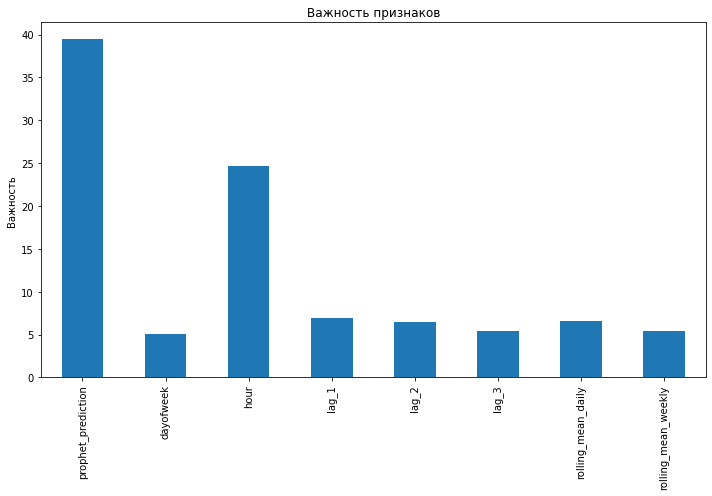

In [79]:
feat_imp = pd.Series(model.feature_importances_, X_train.columns)

fig, ax = plt.subplots(figsize=(10,7))
feat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Сильнее всего влияют предсказания Prophet и час... Остальные признаки оказались не такими важными для модели. Теперь построим график предсказания

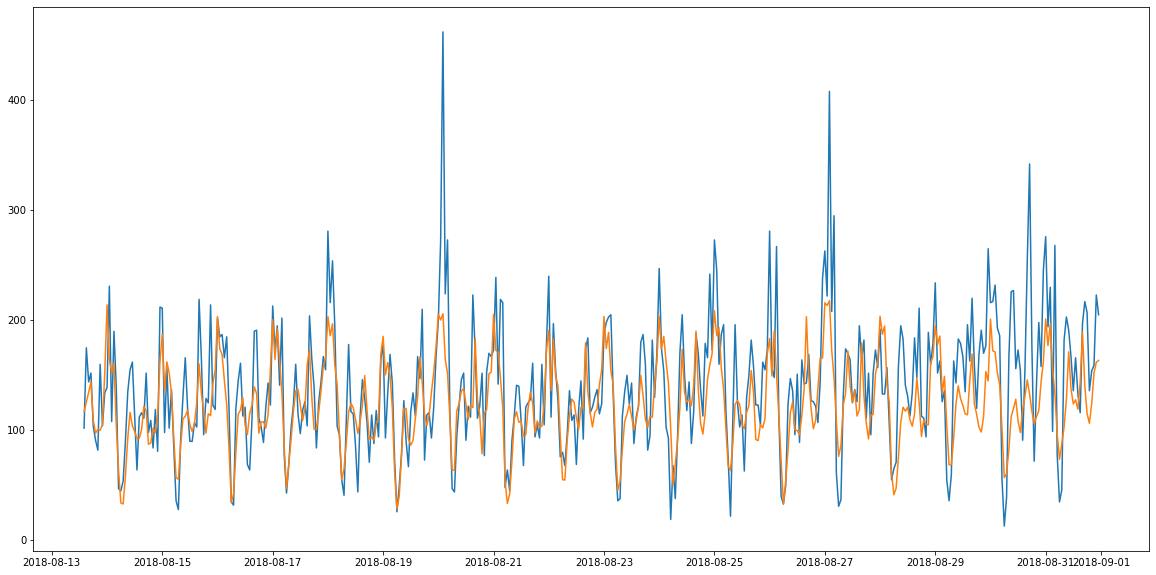

In [80]:
plt.figure(figsize=(20,10))
plt.plot(data['ds'].loc[3974:], y_test)
plt.plot(data['ds'].loc[3974:], pred)
plt.show()

Видно, что в целом модель довольно неплохо предсказывает, однако на пиках очень большие ошибки

## Вывод

* Во время изучения данных я обнаружил, что в них присутствует четко выраженная дневная сезонность. Пик заказов приходится примерно на 23:00-01:00, потом идет резкий спад, подъем наблюдается только утром; далее в течение дня есть некоторые колебания, а к ночи снова пик

* Во время исследования была проведена работа по созданию признаков: были добавлены календарные признаки (день недели, час в дне), лаги (предыдущие три значения) и скользящие средние (с периодом в неделю и в день), а также предсказания модели `Prophet()`

* Были изучены различные модели: решающее дерево, случайный лес, две реализации бустинга. Лучший результат показала модель catboost

* Результаты лучшей модели:
  * параметры: `CatBoostRegressor(n_estimators=80, depth=6, random_seed=42, verbose=False)`
  * RMSE на тестовой выборке: 43.34

* Самые влиятельные фичи: предсказание модели `Prophet()` и номер часа в сутках, остальные признаки имеют примерно равное влияние, существенно меньшее, чем первые два